## 安装工具包

## 加载数据集

In [1]:
from datasets import load_from_disk

# 从保存的路径重新加载数据集
dataset = load_from_disk('./hateful_memes')


/home/caixuqiang/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from datasets import load_dataset
from PIL import Image
import os
from transformers import AutoImageProcessor, BeitModel
import torch
from datasets import load_dataset
from PIL import Image

image_processor = AutoImageProcessor.from_pretrained("microsoft/beit-base-patch16-224-pt22k")
model = BeitModel.from_pretrained("microsoft/beit-base-patch16-224-pt22k")
# 假设 dataset 是您已经加载的 DatasetDict
# 例如：dataset = load_dataset(...)

def load_image(example):
    # 图像文件的基本路径
    base_path = './hateful_memes/'
    # 更新图像路径为完整路径
    img_path = os.path.join(base_path, example['img'])
    # 加载图像并转换为RGB
    image = Image.open(img_path).convert('RGB')
    
    # 更新example，这里是直接返回更新后的图像对象
    example['img'] = image_processor(image, return_tensors="pt")
    return example

# 应用 map 函数更新数据集中的 img 列
dataset = dataset.map(load_image, batched=False)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of BeitModel were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 处理数据

In [16]:
from transformers import AutoImageProcessor, BeitModel
import torch
from datasets import load_dataset
from PIL import Image

image_processor = AutoImageProcessor.from_pretrained("microsoft/beit-base-patch16-224-pt22k")
model = BeitModel.from_pretrained("microsoft/beit-base-patch16-224-pt22k")
inputs  = dataset['test'][1]["img"]

with torch.no_grad():
    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
list(last_hidden_states.shape)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of BeitModel were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[1, 197, 768]

## TEXT-ONLY

In [3]:
from transformers import AutoProcessor, AutoModelForAudioClassification, AutoModelForPreTraining, AutoModelForMaskedLM, AutoModelForSequenceClassification
import torch.nn as nn
from transformers import AutoTokenizer
import torch
from transformers import AutoModel
from transformers import BertModel
import math
import os
import warnings
from dataclasses import dataclass
from typing import List, Optional, Tuple, Union
import torch.nn.init as init
import torch.utils.checkpoint
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

class text_only_model(nn.Module):
    def __init__(self):
        super(text_only_model, self).__init__()
        # 选择并加载baseModel
        self.bert_base = BertModel.from_pretrained("/home/caixuqiang/bert-base-uncased", output_hidden_states = True)
        #self.bert_base = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/myModel/bert_12layers", output_hidden_states=True)
        #self.bert_base = AutoModelForSequenceClassification.from_pretrained("JerryM/distilbert-base-uncased-finetuned-emotion",output_hidden_states=True)
        #self.bert_base = AutoModelForSequenceClassification.from_pretrained("wofeishenling/autotrain-iemocap_text_4-39809103601", output_hidden_states = True)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, 2)

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        #token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Tuple[torch.Tensor]:
        #print(model.M_12_1.weight)
        outputs = self.bert_base(
            input_ids,
            attention_mask=attention_mask,
            #token_type_ids=token_type_ids,
            #position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs.hidden_states
        #print(hidden_states[1][:, 0, :].shape) #32*768
        # 取出模型的1-12层输出

        #取第12层作为分类器的输入
        logits = self.classifier(hidden_states[12][:, 0, :])
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, 2), labels.view(-1))

        output = (logits,)
        return ((loss,) + output)


In [12]:
# 实例化模型
model = text_only_model()

In [29]:
# 冻结bert模型的参数，使其不参与参数的更新
for param in model.bert_base.parameters():
    param.requires_grad = False

### Trainer

In [13]:
from transformers import Trainer, TrainingArguments

# 设置训练参数
class CustomTrainer(Trainer):
    def create_optimizer(self):
        optimizer_grouped_parameters = [
            {
              "params": self.model.classifier.parameters(),
              "lr": 1e-3,
              "weight_decay": self.args.weight_decay
            },
            {
              "params": self.model.bert_base.parameters(),
              "lr": self.args.learning_rate,
              "weight_decay": self.args.weight_decay
            },
        ]
        self.optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=self.args.learning_rate)
        return self.optimizer

training_args = TrainingArguments(
    output_dir="test_trainer", evaluation_strategy="epoch",
    learning_rate = 5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    #no_cuda=True,
    )

In [14]:
import numpy as np
import evaluate
metric = evaluate.load("/home/caixuqiang/evaluate/metrics/roc_auc")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # 对于二分类问题，使用 sigmoid 函数将 logits 转换为概率值
    # 对于多分类问题，你可能需要使用 softmax 函数
    probabilities = 1 / (1 + np.exp(-logits))[:, 1]

    # 对于二分类问题，你可以直接使用 probabilities
    # 如果是多标签分类，确保你的输出和标签是正确的形式
    return metric.compute(prediction_scores=probabilities, references=labels)

In [15]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_metrics,
)

In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc
1,0.542400,0.714579,0.655379


TrainOutput(global_step=532, training_loss=0.5380397524152484, metrics={'train_runtime': 28.8905, 'train_samples_per_second': 294.214, 'train_steps_per_second': 18.414, 'total_flos': 0.0, 'train_loss': 0.5380397524152484, 'epoch': 1.0})

In [17]:
model.bert_base.save_pretrained("./bert12layer_hatefulmemes")

## IMG-ONLY

In [20]:
from transformers import AutoImageProcessor, BeitModel
import torch.nn as nn
import torch
from typing import List, Optional, Tuple, Union
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
class img_only_model(nn.Module):
    def __init__(self):
        super(img_only_model, self).__init__()
        # 选择basemodel并加载
        #--------------local_model---------------
        self.model = BeitModel.from_pretrained("/home/caixuqiang/beit", output_hidden_states=True)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(768, 2)

    def forward(self, pixel_values: torch.Tensor,labels: Optional[torch.Tensor] = None, ) -> torch.Tensor:
        outputs = self.model(pixel_values)
        hidden_states = outputs.hidden_states
        # 取第1层作为分类器的输入
        logits = self.classifier(hidden_states[12][:, 0, :])

        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, 2), labels.view(-1))

        output = (logits,)
        return ((loss,) + output)


In [26]:
m = img_only_model()

In [11]:
# 冻结参数
for param in m.model.parameters():
   param.requires_grad = False

In [27]:
import numpy as np
import evaluate
metric = evaluate.load("./evaluate/metrics/roc_auc")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # 对于二分类问题，使用 sigmoid 函数将 logits 转换为概率值
    # 对于多分类问题，你可能需要使用 softmax 函数
    probabilities = 1 / (1 + np.exp(-logits))[:, 1]

    # 对于二分类问题，你可以直接使用 probabilities
    # 如果是多标签分类，确保你的输出和标签是正确的形式
    return metric.compute(prediction_scores=probabilities, references=labels)

In [28]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    evaluation_strategy="epoch",
    learning_rate = 1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    output_dir="wofeishenling/wofei",
    #no_cuda=True,
    )

In [29]:
trainer = Trainer(
    model=m,
    #model = AutoModelForPreTraining.from_pretrained("facebook/wav2vec2-base-960h",
    #                        output_hidden_states = True,
    #                        num_labels = 4),
    args=training_args,
    # data_collator = data_collator,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_metrics,
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3), SaveBestModelCallback()]
)

In [30]:
trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc
1,3.681800,1.162108,0.501346
2,0.782500,0.717963,0.550292
3,0.725000,0.711881,0.555954
4,0.659700,0.703986,0.554573
5,0.608200,0.722456,0.541461


TrainOutput(global_step=2660, training_loss=1.249551535011234, metrics={'train_runtime': 764.0845, 'train_samples_per_second': 55.622, 'train_steps_per_second': 3.481, 'total_flos': 0.0, 'train_loss': 1.249551535011234, 'epoch': 5.0})

In [32]:
m.model.save_pretrained('./beit12layers_hatefulmemes')

## FUSION MODEL

In [3]:
import torch
from datasets import load_dataset
from transformers import  Wav2Vec2FeatureExtractor
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import HubertForSequenceClassification, Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification

In [4]:
import torch
import torch.nn as nn
# 简单融合
class Concatenation(nn.Module):
    def __init__(self, feature_size=768):
        super(Concatenation, self).__init__()
        self.classifier = nn.Linear(768*2, 768)

    def forward(self, audio_features, text_features):
        cat_features = torch.cat((audio_features, text_features), dim=1)
        cat_features = self.classifier(cat_features)

        return cat_features

In [5]:
import torch
import torch.nn as nn
d_model = 768
nhead = 8
dropout = 0.1
layer_norm_eps = 1e-5
dim_feedforward = 3072
# 使用注意力机制融合模块
class CoAttention(nn.Module):
    def __init__(self, feature_size=768):
        super(CoAttention, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead)
        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps)
        self.dropout = nn.Dropout(dropout)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.linear1 = nn.Linear(d_model, dim_feedforward)

    def forward(self, af, tf):
        x = self.norm1(af + self._sa_block(af, tf, tf))
        x = self.norm2(x + self._ff_block(x))

        y = self.norm1(tf + self._sa_block(tf, af, af))
        y = self.norm2(y + self._ff_block(y))

        x1 = self.norm1(x + self._sa_block(x, y, y))
        x1 = self.norm2(x1 + self._ff_block(x1))

        y1 = self.norm1(y + self._sa_block(y, x, x))
        y1 = self.norm2(y1 + self._ff_block(y1))

        x2 = self.norm1(x1 + self._sa_block(x1, y1, y1))
        x2 = self.norm2(x2 + self._ff_block(x2))

        y2 = self.norm1(y1 + self._sa_block(y1, x1, x1))
        y2 = self.norm2(y2 + self._ff_block(y2))

        fused_features = (x+y)/2
        return fused_features

    def _sa_block(self, q, k, v):
        x = self.self_attn(q, k, v, need_weights=False)[0]
        return self.dropout1(x)

    # feed forward block
    def _ff_block(self, x):
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout2(x)



In [22]:
from transformers import AutoProcessor, AutoModelForAudioClassification, AutoModelForPreTraining, AutoModelForMaskedLM, AutoModelForSequenceClassification
import torch.nn as nn
from transformers import AutoModel
from transformers import BertModel
import math
import os
import warnings
from dataclasses import dataclass
from typing import List, Optional, Tuple, Union
from transformers import AutoImageProcessor, BeitModel

skew = -4
import torch
import torch.utils.checkpoint
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
class FusionModel(nn.Module):
    def __init__(self):
        super(FusionModel, self).__init__()

        # 分别选择文本basemodel以及语音的basemodel
        self.text_model = BertModel.from_pretrained("./bert12layer_hatefulmemes", output_hidden_states = True)
        #self.audio_model = AutoModelForPreTraining.from_pretrained("facebook/wav2vec2-base", output_hidden_states = True)
        self.img_model = BeitModel.from_pretrained("./beit12layers_hatefulmemes", output_hidden_states=True)
        #self.audio_model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", output_hidden_states = True)
        #self.text_model = AutoModelForSequenceClassification.from_pretrained("/home/caixuqiang/bert12layer_hatefulmemes", output_hidden_states=True)

        # 选择融合机制
        self.fusion_model = CoAttention()
        #self.fusion_model = Concatenation()
        self.dropout = nn.Dropout(0.1)
        self.linear1 = nn.Linear(768*2, 2)
        self.linear = nn.Linear(768, 2) # output features from bert is 768 and 2 is ur number of labels

    def forward(
        self,
        pixel_values: Optional[torch.Tensor] = None,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        return_dict: Optional[bool] = None,
    ) -> Tuple[torch.Tensor]:
        outputs_audio = self.img_model(pixel_values)
        outputs_text  = self.text_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        ## 指定融合的匹配策略
        #layer_fusion1 = self.fusion_model(outputs_audio.hidden_states[1][:,0,:],outputs_text.hidden_states[1][:,0,:])
        #layer_fusion2 = self.fusion_model(outputs_audio.hidden_states[1][:,0,:],outputs_text.hidden_states[5][:,0,:])
        #layer_fusion3 = self.fusion_model(outputs_audio.hidden_states[2][:,0,:],outputs_text.hidden_states[6][:,0,:])
        #layer_fusion4 = self.fusion_model(outputs_audio.hidden_states[3][:,0,:],outputs_text.hidden_states[7][:,0,:])
        layer_fusion5 = self.fusion_model(outputs_audio.hidden_states[12][:,0,:],outputs_text.hidden_states[6][:,0,:])
        #layer_fusion6 = self.fusion_model(outputs_audio.hidden_states[9][:,0,:],outputs_text.hidden_states[10][:,0,:])
        #layer_fusion7 = self.fusion_model(outputs_audio.hidden_states[8][:,0,:],outputs_text.hidden_states[9][:,0,:])
        #layer_fusion8 = self.fusion_model(outputs_audio.hidden_states[11][:,0,:],outputs_text.hidden_states[6][:,0,:])
        #layer_fusion9 = self.fusion_model(outputs_audio.hidden_states[12][:,0,:],outputs_text.hidden_states[7][:,0,:])
        #layer_fusion10 = self.fusion_model(outputs_audio.hidden_states[1][:,0,:],outputs_text.hidden_states[10][:,0,:])
        #layer_fusion11 = self.fusion_model(outputs_audio.hidden_states[7][:,0,:],outputs_text.hidden_states[11][:,0,:])
        #layer_fusion12 = self.fusion_model(outputs_audio.hidden_states[8][:,0,:],outputs_text.hidden_states[12][:,0,:])

        #outputs_fusion = self.w1*layer_fusion1 + self.w2*layer_fusion2 + self.w3*layer_fusion3 + self.w4*layer_fusion4 + self.w5*layer_fusion5 + self.w6*layer_fusion6 + self.w7*layer_fusion7 + self.w8*layer_fusion8 + self.w9*layer_fusion9 + self.w10*layer_fusion10 + self.w11*layer_fusion11 + self.w12*layer_fusion12
        #outputs_fusion = (layer_fusion5 + layer_fusion6 + layer_fusion7)/3.0
        # + layer_fusion10 + layer_fusion11 + layer_fusion12
        #outputs_fusion = 0.0002443*layer_fusion1 + 0.0004886*layer_fusion2 + 0.0009772*layer_fusion3 + 0.0019544*layer_fusion4 + 0.0039088*layer_fusion5 + 0.0078176*layer_fusion6 + 0.0156352*layer_fusion7 + 0.0312704*layer_fusion8 + 0.0625408*layer_fusion9 + 0.1250816*layer_fusion10 + 0.2501632*layer_fusion11 + 0.5003264*layer_fusion12


        # 将融合好的特征进行分类
        logits = self.linear(layer_fusion5)
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, 2), labels.view(-1))

        output = (logits,)
        res = ((loss,) + output)
        return res
        

In [23]:
model = FusionModel()

In [24]:
for param in model.img_model.parameters():
    param.requires_grad = False

for param in model.text_model.parameters():
    param.requires_grad = False

In [25]:
from transformers import TrainingArguments, Trainer, TrainerCallback

training_args = TrainingArguments(
    output_dir="test_trainer", evaluation_strategy="epoch",
    learning_rate = 5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    save_strategy = 'steps',
    #no_cuda = True,
    )

In [26]:
import numpy as np
import evaluate
metric = evaluate.load("./evaluate/metrics/roc_auc")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # 对于二分类问题，使用 sigmoid 函数将 logits 转换为概率值
    # 对于多分类问题，你可能需要使用 softmax 函数
    probabilities = 1 / (1 + np.exp(-logits))[:, 1]

    # 对于二分类问题，你可以直接使用 probabilities
    # 如果是多标签分类，确保你的输出和标签是正确的形式
    return metric.compute(prediction_scores=probabilities, references=labels)

In [27]:
from transformers import Trainer, TrainingArguments
import torch

class CustomTrainer(Trainer):
    def create_optimizer(self):
        optimizer_grouped_parameters = [
            {
              "params": self.model.linear.parameters(),
              "lr": 1e-3,
              "weight_decay": self.args.weight_decay
            },
            {
              "params": self.model.fusion_model.parameters(),
              "lr": self.args.learning_rate,
              "weight_decay": self.args.weight_decay
            },
        ]
        self.optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=self.args.learning_rate)
        return self.optimizer

In [28]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    # data_collator=data_collator,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    #tokenizer = feature_extractor,
    compute_metrics=compute_metrics,
    #callbacks=[MyCallback],
)

In [ ]:
trainer.train()

In [ ]:
torch.cuda.empty_cache()

# tsne

In [200]:
skew = 2

In [201]:
from transformers import AutoProcessor, AutoModelForAudioClassification, AutoModelForPreTraining, AutoModelForMaskedLM, AutoModelForSequenceClassification
import torch.nn as nn
from transformers import AutoModel
from transformers import BertModel
import math
import os
import warnings
from dataclasses import dataclass
from typing import List, Optional, Tuple, Union

import torch
import torch.utils.checkpoint
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
class eval_FusionModel(nn.Module):
    def __init__(self):
        super(eval_FusionModel, self).__init__()

        # 分别选择文本basemodel以及语音的basemodel
        self.text_model = model.text_model
        self.audio_model = model.audio_model
        #self.audio_model = Wav2Vec2ForSequenceClassification.from_pretrained("/content/drive/MyDrive/myModel/wav2vec2_superb_12layers", output_hidden_states = True)
        #self.audio_model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", output_hidden_states = True)
        #self.text_model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/myModel/bert_12layers", output_hidden_states=True)

        # 选择融合机制
        self.fusion_model = model.fusion_model
        state_dict = torch.load('/home/caixuqiang/skew2/fusion_3.0_epoch')
        self.fusion_model.load_state_dict(state_dict)
        #self.fusion_model = Concatenation()
        self.dropout = nn.Dropout(0.1)
        self.linear1 = nn.Linear(768*2, 4)
        self.linear = nn.Linear(768, 4) # output features from bert is 768 and 2 is ur number of labels

    def forward(
        self,
        input_values: Optional[torch.Tensor] = None,
        attention_mask_audio: Optional[torch.Tensor] = None,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        return_dict: Optional[bool] = None,
    ) -> Tuple[torch.Tensor]:
        outputs_audio = self.audio_model(input_values, attention_mask=attention_mask_audio)
        outputs_text  = self.text_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        ## 指定融合的匹配策略
        #layer_fusion1 = self.fusion_model(outputs_audio.hidden_states[1][:,0,:],outputs_text.hidden_states[1][:,0,:])
        #layer_fusion2 = self.fusion_model(outputs_audio.hidden_states[1][:,0,:],outputs_text.hidden_states[5][:,0,:])
        #layer_fusion3 = self.fusion_model(outputs_audio.hidden_states[2][:,0,:],outputs_text.hidden_states[6][:,0,:])
        #layer_fusion4 = self.fusion_model(outputs_audio.hidden_states[3][:,0,:],outputs_text.hidden_states[7][:,0,:])
        layer_fusion5 = self.fusion_model(outputs_audio.hidden_states[8-skew][:,0,:],outputs_text.hidden_states[8][:,0,:])
        layer_fusion6 = self.fusion_model(outputs_audio.hidden_states[9-skew][:,0,:],outputs_text.hidden_states[9][:,0,:])
        layer_fusion7 = self.fusion_model(outputs_audio.hidden_states[10-skew][:,0,:],outputs_text.hidden_states[10][:,0,:])
        layer_fusion8 = self.fusion_model(outputs_audio.hidden_states[11-skew][:,0,:],outputs_text.hidden_states[11][:,0,:])
        layer_fusion9 = self.fusion_model(outputs_audio.hidden_states[12-skew][:,0,:],outputs_text.hidden_states[12][:,0,:])
        #layer_fusion10 = self.fusion_model(outputs_audio.hidden_states[1][:,0,:],outputs_text.hidden_states[10][:,0,:])
        #layer_fusion11 = self.fusion_model(outputs_audio.hidden_states[7][:,0,:],outputs_text.hidden_states[11][:,0,:])
        #layer_fusion12 = self.fusion_model(outputs_audio.hidden_states[8][:,0,:],outputs_text.hidden_states[12][:,0,:])

        #outputs_fusion = self.w1*layer_fusion1 + self.w2*layer_fusion2 + self.w3*layer_fusion3 + self.w4*layer_fusion4 + self.w5*layer_fusion5 + self.w6*layer_fusion6 + self.w7*layer_fusion7 + self.w8*layer_fusion8 + self.w9*layer_fusion9 + self.w10*layer_fusion10 + self.w11*layer_fusion11 + self.w12*layer_fusion12
        outputs_fusion = (layer_fusion5 + layer_fusion6 + layer_fusion7 + layer_fusion8 + layer_fusion9)/5.0
        # + layer_fusion10 + layer_fusion11 + layer_fusion12
        #outputs_fusion = 0.0002443*layer_fusion1 + 0.0004886*layer_fusion2 + 0.0009772*layer_fusion3 + 0.0019544*layer_fusion4 + 0.0039088*layer_fusion5 + 0.0078176*layer_fusion6 + 0.0156352*layer_fusion7 + 0.0312704*layer_fusion8 + 0.0625408*layer_fusion9 + 0.1250816*layer_fusion10 + 0.2501632*layer_fusion11 + 0.5003264*layer_fusion12


        # 将融合好的特征进行分类

        return (layer_fusion9)

In [202]:
eval_model = eval_FusionModel()

In [203]:
from transformers import AutoProcessor, AutoModelForAudioClassification, AutoModelForPreTraining, AutoModelForMaskedLM, AutoModelForSequenceClassification, Wav2Vec2ForSequenceClassification
import torch.nn as nn
from transformers import AutoTokenizer
import torch
from transformers import AutoModel
from transformers import BertModel
import math
import os
import warnings
from dataclasses import dataclass
from typing import List, Optional, Tuple, Union
import torch.nn.init as init
import torch.utils.checkpoint
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from tqdm import tqdm
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel

# 初始化Bert模型和tokenizer
#model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
#eval_model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/myModel/skew4/bert_1.0_epoch", output_hidden_states=True)
#model = AutoModelForPreTraining.from_pretrained("facebook/wav2vec2-base", output_hidden_states = True)
#model = Wav2Vec2ForSequenceClassification.from_pretrained("/content/drive/MyDrive/myModel/wav2vec2_1.0_epoch", output_hidden_states = True)
#model = model.text_model
# 提取标签和特征向量的列表
labels_list = []
hidden_states_list = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
eval_model.to(device)
# 遍历数据集
for example in tqdm(tokenized_test_dataset):
    # 处理输入数据
    input_ids = example['input_ids']
    attention_mask = example['attention_mask']
    input_values = example['input_values']
    attention_mask_audio = example['attention_mask_audio']

    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    input_values = input_values.to(device)
    attention_mask_audio = attention_mask_audio.to(device)
    # 将输入数据传递给BERT模型
    #outputs = model(input_ids=input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0))
    #outputs = model(input_values.unsqueeze(0), attention_mask=attention_mask_audio.unsqueeze(0))
    outputs = eval_model(input_ids=input_ids.unsqueeze(0), attention_mask=attention_mask.unsqueeze(0),input_values = input_values.unsqueeze(0), attention_mask_audio=attention_mask_audio.unsqueeze(0))

    # 提取特定层的隐藏状态
    selected_layer = outputs.detach().cpu().numpy()
    #selected_layer = outputs.detach().cpu().numpy()
    #selected_layer = outputs
    # 将标签和特征向量添加到列表中
    labels_list.append(example['labels'])
    hidden_states_list.append(selected_layer)
    del outputs, selected_layer

# 将标签列表和特征向量列表转换为张量
labels_tensor = torch.tensor(labels_list)
hidden_states_tensor = torch.tensor(hidden_states_list)
hidden_states_tensor = hidden_states_tensor.squeeze(1)

  0%|          | 0/1241 [00:00<?, ?it/s]

100%|██████████| 1241/1241 [00:39<00:00, 31.72it/s]


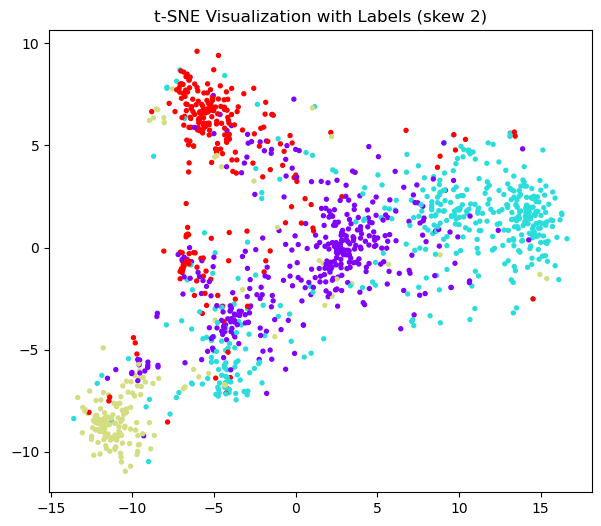

In [204]:
tsne = TSNE(n_components=2, perplexity=150.0, random_state=42)
tsne_vectors = tsne.fit_transform(hidden_states_tensor)

# 绘制t-SNE可视化结果，并根据标签进行着色
plt.figure(figsize=(7, 6))
scatter = plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1], c=labels_tensor, cmap='rainbow', s=8)
plt.title("t-SNE Visualization with Labels (skew {})".format(skew))
plt.colorbar(scatter).remove()   # 显示图例
plt.savefig(f'single_layer_2_3.png')
plt.show()